In [1]:
import numpy as np
import pandas as pd
import time
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier

In [12]:
# load data from pickle oject
fiducial_pt_full =pd.read_pickle('fiducial_pt_full.pkl')
label_full= pd.read_pickle('label_full.pkl')

## Split into training & test set
X_train, X_test, y_train, y_test = train_test_split(fiducial_pt_full, label_full, test_size=0.2, random_state=42)

In [13]:
# pairwise distance calculation (can replace it with other feature engineering procedure)

# extract pairwise distance as features (78*77/2=3003 features)
# nrow=number of records of the dataset; ncol=3003
start_time = time.time()
feature_train = np.stack((metrics.pairwise_distances(X_train[i])[np.triu_indices(78, k = 1)] for i in range(X_train.shape[0])))
print('Training feature extraction takes %s seconds.'%round((time.time()-start_time),3))

start_time = time.time()
feature_test = np.stack((metrics.pairwise_distances(X_test[i])[np.triu_indices(78, k = 1)] for i in range(X_test.shape[0])))
print('Test feature extraction takes %s seconds.'%round((time.time()-start_time),3))

/Users/XiangningHan/env_tools/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):


Training feature extraction takes 1.31 seconds.


/Users/XiangningHan/env_tools/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):


Test feature extraction takes 0.401 seconds.


In [14]:
#balance test set
emotion_1 = y_test[y_test == 1]
emotion_0 = y_test[y_test== 0]
feature_1 = feature_test[y_test==1]
feature_0 = feature_test[y_test==0]
bal_feature = np.concatenate((feature_1[0:130],feature_0[0:130]),axis=0)
bal_y = np.concatenate((emotion_1[0:130],emotion_0[0:130]),axis=0)


## Train Model using k-neighbors=3

In [15]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
#Standardize
standard_fit = StandardScaler().fit(feature_train)
feature_train_knn_norm = standard_fit.transform(feature_train)
feature_test_knn_norm=standard_fit.transform(feature_test)
start=time.time()
clf_knn = KNeighborsClassifier(n_neighbors = 3)
model_k_3=clf_knn.fit(feature_train_knn_norm,y_train)
prob_train = clf_knn.predict_proba(feature_test_knn_norm)
print('Training time cost {:.2f} s'.format(time.time()-start))

Training time cost 12.64 s


In [16]:
print('accuracy', model_k_3.score(feature_test,y_test).round(6))
prob_test = model_k_3.predict_proba(feature_test)
print(f'Test ROC AUC  Score: {metrics.roc_auc_score(y_test, prob_test[:,1])}')
#print('pred prob\n', prob_test)

accuracy 0.768333
Test ROC AUC  Score: 0.5


## Choose the best K-Neighbors  by using 5-fold cross validation

[0.8012499999999999, 0.8104166666666666, 0.8025, 0.8129166666666666, 0.8091666666666667, 0.8125, 0.8133333333333332, 0.8154166666666667, 0.8145833333333332, 0.8125, 0.8120833333333334, 0.8133333333333335]
Training time cost 626.21 s


Text(0, 0.5, 'Cross validated accuracy')

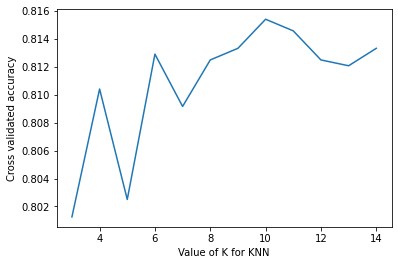

In [17]:
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
start=time.time()
cv_splitter = KFold(n_splits = 5, shuffle = True, random_state = 1)
knn_scores = []
k_range=range(3,15)
for i in k_range:
    clf = KNeighborsClassifier(n_neighbors= i)
    cv_scores = cross_val_score(clf,feature_train_knn_norm, y_train, cv =cv_splitter, scoring = 'accuracy')
    knn_scores.append(cv_scores.mean())
print(f'{knn_scores}')
print('Training time cost {:.2f} s'.format(time.time()-start))
plt.plot(k_range, knn_scores)
plt.xlabel("Value of K for KNN")
plt.ylabel("Cross validated accuracy")

The k-neighbors cannot be too small or too big, so we choose the k-range from (3,15) to choose best k-neighbor where the knn_score is maximum.

In [18]:
best_k=k_range[knn_scores.index(max(knn_scores))]

In [19]:
#best model
from sklearn.neighbors import KNeighborsClassifier
start=time.time()
best_k=k_range[knn_scores.index(max(knn_scores))]
clf_knn = KNeighborsClassifier(n_neighbors = best_k)
model=clf_knn.fit(feature_train_knn_norm,y_train)
prob_train = clf_knn.predict_proba(feature_train_knn_norm)
print('Training time cost {:.2f} s'.format(time.time()-start))

Training time cost 59.26 s


In [20]:
start=time.time()
print('accuracy', model.score(feature_test,y_test).round(6))
prob_test = model.predict_proba(feature_test)
print(f'Test ROC AUC  Score: {metrics.roc_auc_score(y_test, prob_test[:,1])}')
print('Testing time cost {:.2f} s'.format(time.time()-start))
#print('pred prob\n', prob_test)

accuracy 0.768333
Test ROC AUC  Score: 0.5115872594765837
Testing time cost 20.88 s


## weighted accuracy

In [21]:
weight_data = np.zeros(len(y_test))
y_pred=model.predict(feature_test)
for v in np.unique(y_test):
    weight_data[y_test==v] = 0.5*len(y_test)/np.sum(y_test==v)
weighted_acc = np.sum(weight_data * (y_pred==y_test)/np.sum(weight_data))
print('weighted accuracy',weighted_acc)

weighted accuracy 0.5


## Balanced test 

In [22]:
print('accuracy', model.score(bal_feature,bal_y).round(6))
prob_test = model.predict_proba(bal_feature)
print(f'Test ROC AUC  Score: {metrics.roc_auc_score(bal_y, prob_test[:,1])}')
#print('pred prob\n', prob_test)

accuracy 0.5
Test ROC AUC  Score: 0.5115384615384615
